# Analysis of Beijing housing prices

## Content

- Imports
- Defining functions
- Running functions

## Imports

In [20]:
# standard libraries
import os
from datetime import datetime

# data handling and visualization
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# for Q-Q plots
import scipy.stats as stats

# warnings
import warnings
warnings.filterwarnings("ignore")  # disable warnings in this notebook

## Defining functions

### Dataframe handling

In [22]:
'''
# return encoding of file
def detectEncoding(PATH):
    with open(PATH, 'rb') as rawdata:
        result = chardet.detect(rawdata.read(10000))
    return result
'''

"\ndef detectEncoding(PATH):\n    with open(PATH, 'rb') as rawdata:\n        result = chardet.detect(rawdata.read(10000))\n    return result\n"

In [2]:
# loading the data
def createDataframeFromCSV(PATH, encoding, separator):
    if os.path.exists(PATH) and encoding !="" and separator != "":
        rawData = pd.read_csv(PATH, encoding=encoding, sep=separator)
        return rawData  # return dataframe
    else:
        return "ERROR"  # return error

### Profile report

In [3]:
# create ProfileReport
def createProfileReport(df):
    dt = datetime.now().strftime("%H%m%d%m%Y")  # current dateTime for fileName
    profile = ProfileReport(df, minimal=True)
    fileName = f"DataAnalysis{dt}"
    profile.to_file(output_file=fileName)
    return f"File saved: {fileName}.html"

### Dataframe analysis

In [23]:
# detecting and printing information about rare lables
def detectRareLabels(df, columnName):
    data = df[columnName].value_counts()/len(df[columnName])
    print(f"Number of labels in the {columnName} variable: {df[columnName].nunique()}")
    print(f"List of the labels in the {columnName} variable: {df[columnName].unique()}")
    print(f"Value counts for each label:")
    return data

### Visualizations

In [137]:
# subplot generator
def generateSubplots(figs, columns, rows):
    if type(columns) == int and type(rows) == int and (len(figs) == columns * rows):
        return "FIGURE"
        
    else:
        return "ERROR"

In [22]:
# barchart for rare lable visualization
def visualizeRareLabels(df, columnName):
    data = df[columnName].value_counts()/len(df[columnName])
    fig = plt.figure(figsize = (10, 5))
    plt.bar(data.index, data.tolist(), color ='turquoise', width = 0.4)  # creating the bar plot
    plt.xlabel("Label")
    plt.ylabel("Ratio")
    plt.title(columnName)
    return fig

### Dataframe manipulation

In [6]:
# delete empty rows of a dataframe
def deleteEmptyRows(df):
    df.replace('', np.nan, inplace=True)
    df.dropna(inplace=True)
    return df

## Running functions

In [7]:
rawData = createDataframeFromCSV(PATH="../beijing.csv", encoding="iso-8859-1", separator=",")
rawData.head()

C:\Users\leand\AppData\Local\Temp\ipykernel_4512\1997590197.py:4: DtypeWarning: Columns (1,11,12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  rawData = pd.read_csv(PATH, encoding=encoding, sep=separator)


,url,id,Lng,Lat,Cid,tradeTime,DOM,followers,totalPrice,price,...,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
0,https://bj.lianjia.com/chengjiao/101084782030....,101084782030,116.475489,40.019520,1111027376244,2016-08-09,1464.0,106,415.0,31680,...,1.0,2005,3,6,0.217,1.0,0.0,1.0,7,56021.0
1,https://bj.lianjia.com/chengjiao/101086012217....,101086012217,116.453917,39.881534,1111027381879,2016-07-28,903.0,126,575.0,43436,...,1.0,2004,4,6,0.667,1.0,1.0,0.0,7,71539.0
2,https://bj.lianjia.com/chengjiao/101086041636....,101086041636,116.561978,39.877145,1111040862969,2016-12-11,1271.0,48,1030.0,52021,...,4.0,2005,3,6,0.500,1.0,0.0,0.0,7,48160.0
3,https://bj.lianjia.com/chengjiao/101086406841....,101086406841,116.438010,40.076114,1111043185817,2016-09-30,965.0,138,297.5,22202,...,1.0,2008,1,6,0.273,1.0,0.0,0.0,6,51238.0
4,https://bj.lianjia.com/chengjiao/101086920653....,101086920653,116.428392,39.886229,1111027381174,2016-08-28,927.0,286,392.0,48396,...,4.0,1960,2,2,0.333,0.0,1.0,1.0,1,62588.0


In [8]:
data = rawData.copy()  # create copy of originial dataframe
data.head()

,url,id,Lng,Lat,Cid,tradeTime,DOM,followers,totalPrice,price,...,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
0,https://bj.lianjia.com/chengjiao/101084782030....,101084782030,116.475489,40.019520,1111027376244,2016-08-09,1464.0,106,415.0,31680,...,1.0,2005,3,6,0.217,1.0,0.0,1.0,7,56021.0
1,https://bj.lianjia.com/chengjiao/101086012217....,101086012217,116.453917,39.881534,1111027381879,2016-07-28,903.0,126,575.0,43436,...,1.0,2004,4,6,0.667,1.0,1.0,0.0,7,71539.0
2,https://bj.lianjia.com/chengjiao/101086041636....,101086041636,116.561978,39.877145,1111040862969,2016-12-11,1271.0,48,1030.0,52021,...,4.0,2005,3,6,0.500,1.0,0.0,0.0,7,48160.0
3,https://bj.lianjia.com/chengjiao/101086406841....,101086406841,116.438010,40.076114,1111043185817,2016-09-30,965.0,138,297.5,22202,...,1.0,2008,1,6,0.273,1.0,0.0,0.0,6,51238.0
4,https://bj.lianjia.com/chengjiao/101086920653....,101086920653,116.428392,39.886229,1111027381174,2016-08-28,927.0,286,392.0,48396,...,4.0,1960,2,2,0.333,0.0,1.0,1.0,1,62588.0


In [9]:
createProfileReport(data)  # create ProfileReport before analysis

Summarize dataset:   0%|          | 0/35 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\leand\anaconda3\envs\cds106\lib\site-packages\pandas_profiling\profile_report.py:261: UserWarning: Extension  not supported. For now we assume .html was intended. To remove this warning, please use .html or .json.
  warnings.warn(


Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

'File saved: DataAnalysis221013102022.html'

In [24]:
detectRareLabels(data, columnName="renovationCondition")

Number of labels in the renovationCondition variable: 5
List of the labels in the renovationCondition variable: [3 4 1 2 0]
Value counts for each label:


1    0.372418
4    0.368316
3    0.242279
2    0.016904
0    0.000082
Name: renovationCondition, dtype: float64

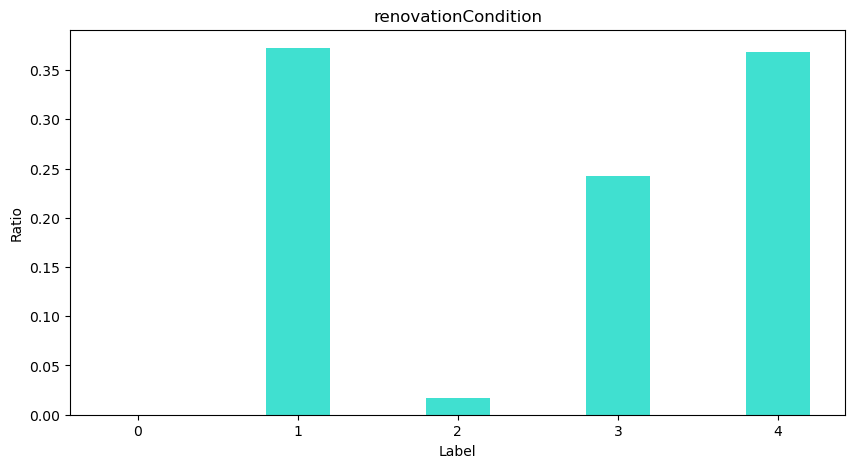

In [129]:
renovationCondition = visualizeRareLabels(data, columnName="renovationCondition")

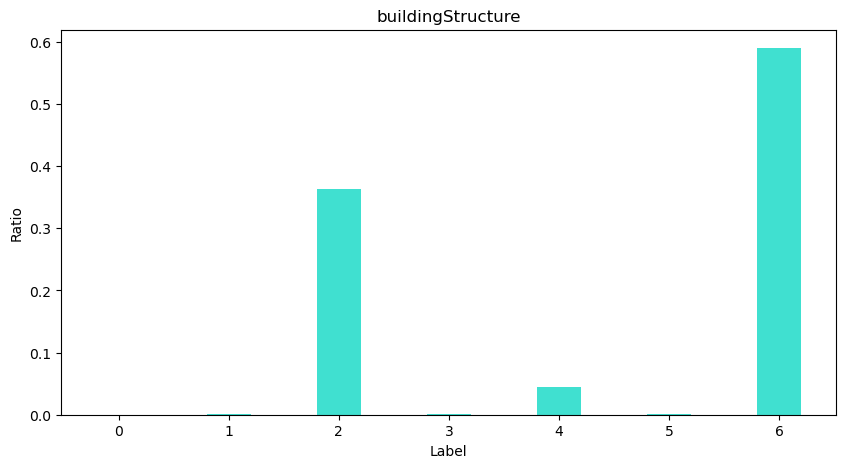

In [130]:
buildingStructure = visualizeRareLabels(data, columnName="buildingStructure")